BrainStation Data Science Program <br>
Capstone project_v1, notebook 1/3 <br>
Angie Nicolás<br>
July 18 2021


# Tracing deforestation in supply chain transactions

## Part I. EDA

For the first part of this project I aim to identify trading operations that may include commodities associated to deforestation risk. This was an exercise  in pooling data from multiple sources. In this notebook we combine data on deforestation associated to Soy & Beef production in Brazil. Data was downloaded in (inconveniently) separate datafiles from Trase (available at https://supplychains.trase.earth/data, accessed July 16,2021).

### Libraries

In [20]:
# Importing usual packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Importing date formatting tools
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

### Data loading 

In [27]:
# My data naming convention: B for Brazil, t for Trase, s for soy, b for beef, 15 for 2015,etc. Bts ->soy, Btb15->beef15
soy_df= pd.read_csv('/Users/angie/Documents/BrainStation_Capstone/data/Trase_BRAZIL_SOY_2.5.1_pc.csv',warn_bad_lines=False)

### Data wrangling for visualizations

In this section our goal is to combine the available soy and beef deforestation data into a single dataframe we can later use for comparative visuals (see Tableau workbook). To get a sense of data format we take a glance at Soy data.

In [3]:
print(f'We have {len(soy_df)} rows and {len(soy_df.columns)} columns of soy data') 

We have 295637 rows and 23 columns of soy data


In [4]:
# Checking first rows of Soy
soy_df.head(1)

,YEAR,COUNTRY OF PRODUCTION,BIOME,STATE,MUNICIPALITY,LOGISTICS HUB,PORT,EXPORTER,EXPORTER GROUP,IMPORTER,...,TYPE,CO2_EMISSIONS_SOY_DEFORESTATION_5_YEAR_ANNUAL_RISK_TCO2,TERRITORIAL_DEFORESTATION_RISK_HA,FOB_USD,CO2_EMISSIONS_TERRITORIAL_DEFORESTATION_RISK_TCO2/HA,SOY_DEFORESTATION_5_YEAR_ANNUAL_RISK_HA,SOY_EQUIVALENT_TONNES,LAND_USE_HA,ZERO_DEFORESTATION_BRAZIL_SOY,TRASE_GEOCODE
0,2017,BRAZIL,AMAZONIA,ACRE,CAPIXABA,CAPIXABA,DOMESTIC CONSUMPTION,DOMESTIC CONSUMPTION,DOMESTIC CONSUMPTION,DOMESTIC CONSUMPTION,...,Soy bean equivalents,NaN,0.00126,0.0,0.894006,NaN,0.000093,0.000031,NaN,BR-1200179


* Who sells: Exporter and Exporter Group 
* Who buys: Importer, Importer Group, Destination Country, and Economic Bloc.
* Fob_USD: Freight on Board. Shipment term that indicates whether the seller or buyer is liable for goods damaged during shipping.
* Commodity equivalent: volume traded in tonnes. To facilitate comparisons between trade flows, Trase data are converted to a common equivalent based on the amount of unprocessed commodity needed to produce it.
* Commodity_deforestation_5_year_annual_risk_Ha: Estimates a trader exposure to the risk that a commodity it is sourcing is directly associated with recent deforestation in the area where it was produced. Measured in hectares. (Trase takes the area of production in a year, then determines how much of it was cleared of native vegetation in recent years, and assigns that area to buyers proportionally to their share of the output from that production area).
* Land_use_Ha: total hectares devoted to that crop or commodity production.
* Zero_deforestation_Brazil = Publicly available *commitments* made by companies that their supply chains will not include commodities produced on recently deforested land.

We change string columns to Sentence Case and format date column as such. 

In [36]:
#To improve readability we format columns in our four df's to lower case.
soy_df.columns= soy_df.columns.str.title()
# String column content
soy_df = soy_df.apply(lambda x: x.str.title() if(x.dtype == 'object') else x)

In [37]:
# Formatting Date columns as dates
soy_df['Year']= pd.to_datetime(soy_df['Year'], format='%Y')

#### EDA

In [38]:
# Counting total null values in df
soy_df.isna().sum().sum()

805379

That's quite a lot of null values!

In [39]:
# Which columns have misisng values
soy_df.isnull().sum()

Year                                                            0
Country Of Production                                           0
Biome                                                           0
State                                                           0
Municipality                                                    0
Logistics Hub                                                   0
Port                                                            0
Exporter                                                        0
Exporter Group                                                  0
Importer                                                        0
Importer Group                                                  0
Country                                                         0
Economic Bloc                                                   0
Type                                                            0
Co2_Emissions_Soy_Deforestation_5_Year_Annual_Risk_Tco2    201470
Territoria

Interestingly, all null values are in land use or deforestation-associated columns. Which means almost two-thirds of our 295637 original rows, do not have information on associated deforestation risk! Given this is our main focus of analysis, I would be inclined to keep only rows that contain at least one of the deforestation metrics, but we explore a bit more.

In [40]:
# Check rows with only missing values. 
sum(map(all, soy_df.isnull()))

23

In [41]:
#These we can surely drop
soy_df = soy_df.dropna(how='all')
soy_df.shape

(295637, 23)

The remaining extremely high proportion of nans continues though. Given they are spread throughout multiple columns and I don't have an objective way to choose which ones to leave or drop, in this exploratory notebook I keep these columns. For modelling, I it will likely be best to drop all rows with missing values in deforestation columns. For now,we explore categorical and numerical variables.

In [42]:
# Exploring categorical variables in Soy data
soy_df.describe(include='object').T

,count,unique,top,freq
Country Of Production,295637,1,Brazil,295637
Biome,295637,7,Mata Atlantica,167708
State,295637,23,Parana,71988
Municipality,295637,2467,Unknown,7358
Logistics Hub,295637,1962,Sao Paulo,77244
Port,295637,44,Paranagua,84034
Exporter,295637,1715,Louis Dreyfus Company Brasil S.A.,68313
Exporter Group,295637,1676,Louis Dreyfus,77481
Importer,295637,1054,Louis Dreyfus,35966
Importer Group,295637,981,Bunge,49356


Above we see we got information on >295 thousand commercial transactions in 2004-2018 involving soy destined to 137 different countries.

In [43]:
# Summary stats of Soy numeric columns
soy_df.round(decimals=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Co2_Emissions_Soy_Deforestation_5_Year_Annual_Risk_Tco2,94167.0,2.436523e+03,1.692948e+04,0.0,1.5,22.8,318.600,965591.1
Territorial_Deforestation_Risk_Ha,139745.0,1.009075e+02,7.731010e+02,0.0,0.1,1.1,13.200,73623.5
Fob_Usd,295637.0,1.103845e+06,5.436982e+06,0.0,4352.9,54419.9,428398.200,673707308.0
Co2_Emissions_Territorial_Deforestation_Risk_Tco2/Ha,139708.0,2.560888e+04,3.598023e+05,0.0,27.0,263.6,2731.525,43111087.7
Soy_Deforestation_5_Year_Annual_Risk_Ha,94132.0,1.416199e+01,1.072326e+02,0.0,0.0,0.1,1.700,8006.0
Soy_Equivalent_Tonnes,295637.0,3.831109e+03,1.719618e+04,0.0,18.0,189.3,1460.500,1766522.9
Land_Use_Ha,288278.0,1.258314e+03,5.230558e+03,0.0,6.7,66.8,500.000,274757.3


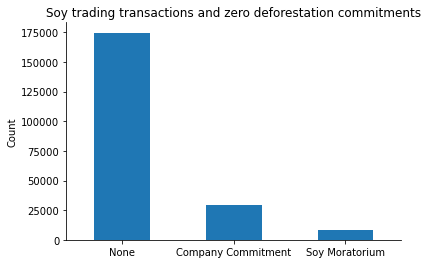

In [45]:
#Exploring soy products Zero_Deforestation commitments
soycfig= soy_df["Zero_Deforestation_Brazil_Soy"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title('Soy trading transactions and zero deforestation commitments')
sns.despine()
#plt.show();
#plt.savefig('/Users/angie/Documents/BrainStation_Capstone/myplots/Soycommits.jpg')

In [47]:
#ABove plot includes nulls. Here I drop them
soynona_df= soy_df.dropna() 
soynona_df.shape

(59497, 23)

In [84]:
soynona_df.to_csv('clean_soy.csv', index=True)

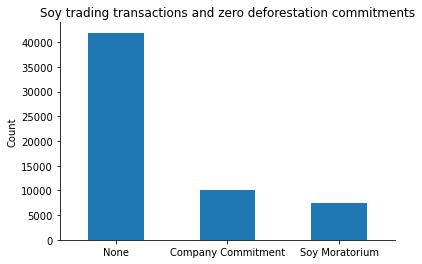

In [49]:
soynona_df["Zero_Deforestation_Brazil_Soy"].value_counts().plot(kind="bar")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title('No-deforestation commits in soy (no-nulls)')
sns.despine()
plt.show();

KeyError: array(['Company Commitment', 'None', 'Soy Moratorium'], dtype=object)

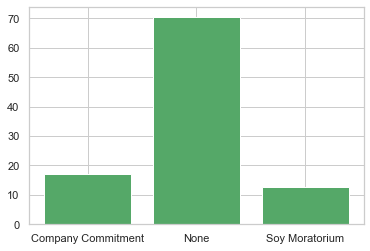

In [71]:
#Barplot of normalized counts
values, counts = np.unique(soynona_df['Zero_Deforestation_Brazil_Soy'],return_counts=True)
normalized_counts = counts/counts.sum()
plt.figure()
plt.bar(values, normalized_counts * 100, color='g')
order=soynona_df.sort_values(np.unique(soynona_df['Zero_Deforestation_Brazil_Soy']),ascending = True)

#plt.xlabel('Commitments')
plt.ylabel('Proportion of transactions (%)')
plt.title("No-deforestation commits in soy (no-nulls)")
sns.despine()
plt.show();

In [65]:
plt.figure(figsize=(10,6))
values, counts = np.unique(soynona_df['Zero_Deforestation_Brazil_Soy'],return_counts=True)
normalized_counts = counts/counts.sum()
# make barplot and sort bars in descending order
sns.barplot(x='Zero_Deforestation_Brazil_Soy', 
            y="normalized_counts",
            data= soynona_df, 
            order=soynona_df.sort_values('normalized_values',ascending = True))
# set labels
plt.xlabel("Commits", size=15)
plt.ylabel("Proportion(%)", size=15)
plt.title("No-deforestation commits in soy (no-nulls)", size=18)
plt.tight_layout()
#plt.savefig("sort_bars_in_barplot_descending_order_Seaborn_Python.png", dpi=100)

NameError: name 'normalized_values' is not defined

<Figure size 720x432 with 0 Axes>

In future iterations, I'll print this as proportions. For now, let's just let the sheer number of soy transactions that are not associated to any type of non-deforestation commitment sink in.

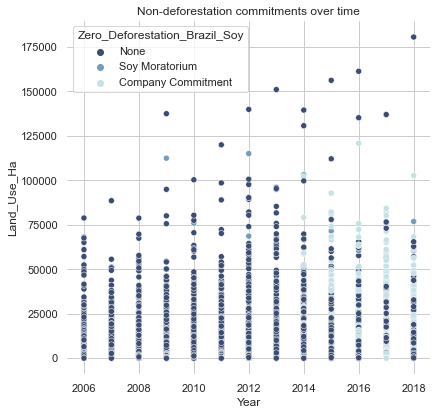

In [59]:
#Scatter plot for latter
sns.set_theme(style="whitegrid")
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
commits = ["None", "Soy Moratorium", "Company Commitment"]
sns.scatterplot(x="Year", y="Land_Use_Ha",
                hue="Zero_Deforestation_Brazil_Soy", #size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=commits,
                #sizes=(1, 8), linewidth=0,
                data=soynona_df, ax=ax).set_title('Non-deforestation commitments over time');

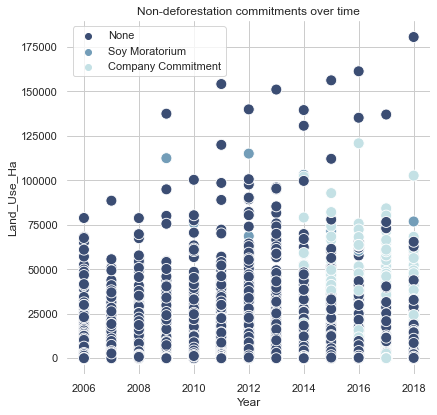

In [81]:
#Scatter plot for latter
sns.set_theme(style="whitegrid")
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
commits = ["None", "Soy Moratorium", "Company Commitment"]
sns.scatterplot(x="Year", y="Land_Use_Ha",
                hue="Zero_Deforestation_Brazil_Soy", #size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=commits,
                #sizes=(1, 15), linewidth=0,
                s=120,
                data=soynona_df, ax=ax).set_title('Non-deforestation commitments over time')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:]);

In [ ]:
soy_df.columns

In [ ]:
soy_df["Soy_Deforestation_5_Year_Annual_Risk_Ha"].value_counts().plot(kind="bar")
sns.despine()
plt.xticks(rotation=0)
plt.title('Soy transactions and non deforestation commitments')
plt.ylabel('Counts (mill)')
plt.xlabel('Name of public commitment')
#plt.show();
plt.savefig('/Users/angie/Documents/BrainStation_Capstone/myplots/Beefcommits.jpg')

In [ ]:
soy_df["Zero_Deforest_Commit"].value_counts(normalize=True).plot(kind="bar")
sns.despine()
plt.xticks(rotation=0)
plt.title('Zero_Deforest_Commit')
plt.ylabel('Counts (mill)')
plt.xlabel('Name of public commitment')
plt.show();
#plt.savefig('/Users/angie/Documents/BrainStation_Capstone/myplots/Beefcommits.jpg')
sns.despine()

In [ ]:
df = sns.load_dataset("tips")
x, y, hue = "day", "proportion", "sex"
hue_order = ["Male", "Female"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)

Notice the y axis is in a scale of millions (1e6 overlapping with first letter of title). We can see most beef transactions were NOT associated to any zero deforestation commitment.

#### Comparing soy & beef

I thought in order to make comparisons and visual explorations it would help to stack our soy and beef dfs into one. We now check if column order would allow that. <br> (Note to reader: apologies for jumping between soy and beef combined data sets in advance)

In [ ]:
print(f'There are {len(soy_df.columns)} columns in Soy data, and {len(beef15_df.columns)} columns in Beef data, but are they the same?')

In [ ]:
# List of columns of each dataframe
soy_cols=list(soy_df.columns)
beef15_cols=list(beef15_df.columns)
beef16_cols=list(beef16_df.columns)
beef17_cols=list(beef16_df.columns)

# Creating small view df just to compare column names and order. 
#(Yes, I realize this archaic method would be useless with more features, but it's what I could do)
match = pd.DataFrame()
match['Soy']  = soy_cols
match['Beef15'] = beef15_cols
match['Beef16'] = beef16_cols
match['Beef17'] = beef17_cols
match

Notice that column 'Port' in Soy df (row6) misaligns comparable columns across datasets. As we don't have an equivalent column for beef data, we drop it for now. In an effort to remove unnecessary columns we also drop those related to logistics, Country Of Production (redundant, since it's all Brazil data), individual municipalities, import and exporters (keeping only groups) and CO2 emissions that we will not analyze in this project.

In [ ]:
# Removing extras from original Soy df
soy_df= soy_df.drop(['Country Of Production','Municipality','Logistics Hub','Port','Exporter', 'Importer','Co2_Emissions_Soy_Deforestation_5_Year_Annual_Risk_Tco2','Co2_Emissions_Territorial_Deforestation_Risk_Tco2/Ha'], axis=1)

#Adding a column to indicate all these rows came from Soy df
soy_df['Product_Descr']='Soy'
soy_df.shape

We now do the same with beef dfs, removing equivalent columns

In [ ]:
# Removing from Beef dfs 
#2015
beef15_df= beef15_df.drop(['Country Of Production','Municipality','Logistics Hub','Exporter', 'Importer','Co2_Emissions_Territorial_Deforestation_Risk_Tco2','Co2_Emissions_Cattle_Deforestation_5_Year_Annual_Risk'], axis=1)
beef15_df.shape

In [ ]:
#2016
beef16_df= beef16_df.drop(['Country Of Production','Municipality','Logistics Hub','Exporter', 'Importer', 'Co2_Emissions_Territorial_Deforestation_Risk_Tco2','Co2_Emissions_Cattle_Deforestation_5_Year_Annual_Risk'], axis=1)
beef16_df.shape

In [ ]:
#2017
beef17_df= beef17_df.drop(['Country Of Production','Municipality','Logistics Hub','Exporter', 'Importer','Co2_Emissions_Territorial_Deforestation_Risk_Tco2','Co2_Emissions_Cattle_Deforestation_5_Year_Annual_Risk'], axis=1)
beef17_df.shape

We compare rearranged columns of soy and beef

In [ ]:
# Creating small view df for chekcing new column order
soy_cols=list(soy_df.columns)
beef15_cols=list(beef15_df.columns)
beef16_cols=list(beef16_df.columns)
beef17_cols=list(beef17_df.columns)

rematch = pd.DataFrame()
rematch['Soy']  = soy_cols
rematch['Beef15'] = beef15_cols
rematch['Beef16'] = beef16_cols
rematch['Beef17'] = beef17_cols
rematch

Almost there! We just need to match corresponding columns with the same name.

In [ ]:
# Locating columns in one commodity but not the other
uncommon = []
for name in beef15_cols:
    if name not in soy_cols:
        uncommon.append(name)
        
print(f'There are {len(uncommon)}/16 columns in soy df that need renaming to match beef df. They are: {uncommon}')

Finally we rename the above mismatching columns so soy and beef column names match prior to concatenating

In [ ]:
#Original name consolidating
soy_df = soy_df.rename(columns={'Soy_Deforestation_5_Year_Annual_Risk_Ha': 'Deforest_5Y_Ann_risk', 'Soy_Equivalent_Tonnes': 'Commodity_Eq_Tonnes', 'Zero_Deforestation_Brazil_Soy':'Zero_Deforest_Commit'})
beef15_df = beef15_df.rename(columns={'Cattle_Deforestation_5_Year_Annual_Risk': 'Deforest_5Y_Ann_risk', 'Beef_Equivalent_Tonnes':'Commodity_Eq_Tonnes','Land_Use':'Land_Use_Ha', 'Zero_Deforestation_Brazil_Beef': 'Zero_Deforest_Commit'})
beef16_df = beef16_df.rename(columns={'Cattle_Deforestation_5_Year_Annual_Risk': 'Deforest_5Y_Ann_risk', 'Beef_Equivalent_Tonnes':'Commodity_Eq_Tonnes','Land_Use':'Land_Use_Ha', 'Zero_Deforestation_Brazil_Beef': 'Zero_Deforest_Commit'})
beef17_df= beef17_df.rename(columns={'Cattle_Deforestation_5_Year_Annual_Risk': 'Deforest_5Y_Ann_risk', 'Beef_Equivalent_Tonnes':'Commodity_Eq_Tonnes','Land_Use':'Land_Use_Ha', 'Zero_Deforestation_Brazil_Beef': 'Zero_Deforest_Commit'})

In [ ]:
#Combining soy and beef into one df for 2015-2017
frames = [soy_df, beef15_df, beef16_df,beef17_df] #each df has same 16 columns
soybeef_df = pd.concat(frames)
soybeef_df.shape 

In [ ]:
# Saving merged soybeef as .csv
soybeef_df.to_csv(r'/Users/angie/Documents/BrainStation_Capstone/data/BraSoyBeef.csv',date_format='%Y')

In [ ]:
# Checking first rows of our combined df
soybeef_df.head(2)

In [ ]:
# Quickly exploring both crops land use over time
sns.lineplot(data=soybeef_df, x="Year", y="Land_Use_Ha", hue="Type")
plt.title('Soy and beef land use over time')
sns.despine();

During this 14 year period, the number of land hectares devoted to soy crops fluctuated around 1200. No strong directional trends are apparent. For plots like these, it's likely better to explore each commodity separately after all or to create a reduced df filtering only for years where both commodities have data.This is the combined dataframe I hope to use to compare both commodities in the overlapping year through visualizations. 

In [ ]:
# Didn't figure out quickly how to filter rows by desired date range ( 2015-2017), so filtering just> 2015
soybeef_filt_df = soybeef_df[soybeef_df['Year'].dt.strftime('%Y') >= '2015']

In [ ]:
sns.lineplot(data=soybeef_filt_df, x="Year", y="Land_Use_Ha", hue="Type")
plt.title('Soy and beef land use over time')
sns.despine();

There appears to be a problem in beef LandUse data, more cleaning and date reformatting is needed in oder to explore it, but due to time constraints, I stoped beef breakdown here.

For the exploratory data analysis section below, and in order to make sense of more years of data, we will focus only on soy data.

In [ ]:
# Random quick check for extremely high (or low) deforestation risks transactions. Here outliers as the 95% percentile
deforest_threshold = np.percentile(soy_df['Territorial_Deforestation_Risk_Ha'], 95)
deforest_threshold

In [ ]:
#Poor attempt at an -invisible- violin plot exploring biomes or regions affected by transactions. More like flute plot
ax = sns.violinplot(x="Biome", y="Land_Use_Ha", data=soy_df)
plt.title('Land use by biomes')
sns.despine();

In [ ]:
soy_df.head(1)

In [ ]:
# A quick loook at deforestation 5 year annual risk suggest it was on a decreasing trend 2015-2017.
sns.scatterplot(data=beef_df, x="Year", y="Cattle_Deforestation_5_Year_Annual_Risk");
plt.title('Cattle Deforestation 5Y annual risk 2015-2017')
sns.despine();

 ### Exploring num. variable distributions

In [ ]:
# Deforestation risk
plt.plot(1,3,1)
plt.hist(soy_df['Territorial_Deforestation_Risk_Ha'],bins=25, log=True)
plt.ylabel('Frequency (log)')
plt.title('Soy Deforestation Risk (Ha)')

According to this, most transactions have low soy deforestation risk

In [ ]:
# Soy Deforestation_5_Year_Annual_Risk_Ha
# Deforestation risk
plt.plot(1,3,1)
plt.hist(soy_df['Land_Use_Ha'],bins=10, log= True )
plt.ylabel('Frequency')
plt.title('Distribution of Soy Land_Use(Ha)')

Not the most informative way to visualize the land use, but, expectedly, most transactions are from <200kHa.

In [ ]:
#Creating a reduced version of the data with only numeric variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
soynum_df=soy_df.select_dtypes(include=numerics)
soynum_df.shape

In [ ]:
# Exploring colinearity between numeric variables for later modelling
sns.pairplot(soynum_df, corner=True)
plt.show()

These plots show some expected linear relationships, for example, the more expansive transactions are in terms of LandUse the more tonnes of soy produced. Similarly,using Fob_Usd as a proxy for transaction (and associated shipment) value, we see more voluminous transactions(higher Commodity_Eq_Tonnes) are associated with higher value (although notice many transactions of ~1tonne are associated with shipment values close to zero). But other relationships are perhaps less intuitive, such as the bottom left corner, showing no linear relationship between territorial deforestation risk and land use. In fact it appears as if transactions with highest deforestation risk are those associated to fewest hectares.

## Conclusions: <br>

I could continue exploring this dataset literally for hours, but due to time constraints I pause for now. For our purposes our main insights are: 
* Brazil exported soy to 137 countries (2004-2018) and beef to a whopping 150 countries between 2015-2017 alone.
* The largest proportion of beef originated from the Amazonia biome.
* The largest proportion of soy and beef transactions did not abide to any public Zero deforestation commitment during the study period.